In [1]:
import tensorflow as tf

data_dir = r"C:\Users\Owner\Desktop\python\dataset-resized"
img_height = 96
img_width = 96
batch_size = 32

# Training split
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="int"
)

# ✅ Save class names right here
class_names = train_ds.class_names
print("Classes:", class_names)

# Test split
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="int"
)




Found 1076 files belonging to 2 classes.
Using 861 files for training.
Classes: ['paper', 'plastic']
Found 1076 files belonging to 2 classes.
Using 215 files for validation.


In [2]:
# Just check shapes like in FashionMNIST
for images, labels in train_ds.take(1):
    print("Train batch images shape:", images.shape)
    print("Train batch labels shape:", labels.shape)

for images, labels in test_ds.take(1):
    print("Test batch images shape:", images.shape)
    print("Test batch labels shape:", labels.shape)


Train batch images shape: (32, 96, 96, 3)
Train batch labels shape: (32,)
Test batch images shape: (32, 96, 96, 3)
Test batch labels shape: (32,)


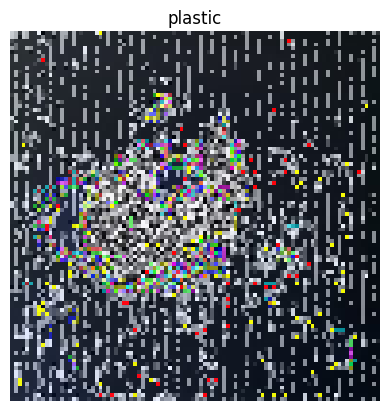

In [3]:
import matplotlib.pyplot as plt

# Take one batch from the dataset
for images, labels in train_ds.take(1):
    sample_img = images[4].numpy()   # pick the 5th image in the batch
    sample_label = labels[4].numpy()

plt.imshow((sample_img * 255).astype("uint8"))
plt.title("paper" if sample_label == 0 else "plastic")
plt.axis("off")
plt.show()


In [4]:
class_names = train_ds.class_names  # ['paper', 'plastic']

for images, labels in train_ds.take(1):
    sample_label = labels[4].numpy()
    print("Label index:", sample_label)
    print("Class name:", class_names[sample_label])


Label index: 0
Class name: paper


In [5]:
class_names = ['paper', 'plastic']
len(class_names)


2

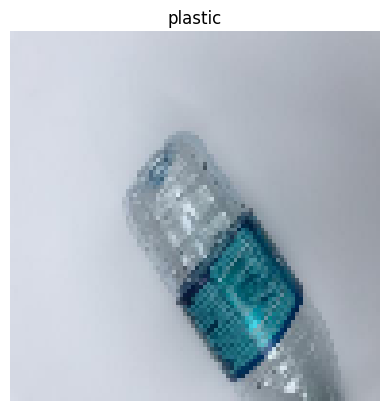

In [6]:
import matplotlib.pyplot as plt

# class_names is provided by train_ds
class_names = train_ds.class_names  # ['paper', 'plastic']

# Take one batch from dataset
for images, labels in train_ds.take(1):
    sample_img = images[17].numpy()
    sample_label = labels[17].numpy()

plt.imshow(sample_img.astype("uint8"))   # convert back to uint8 for imshow
plt.title(class_names[sample_label])
plt.axis("off")
plt.show()


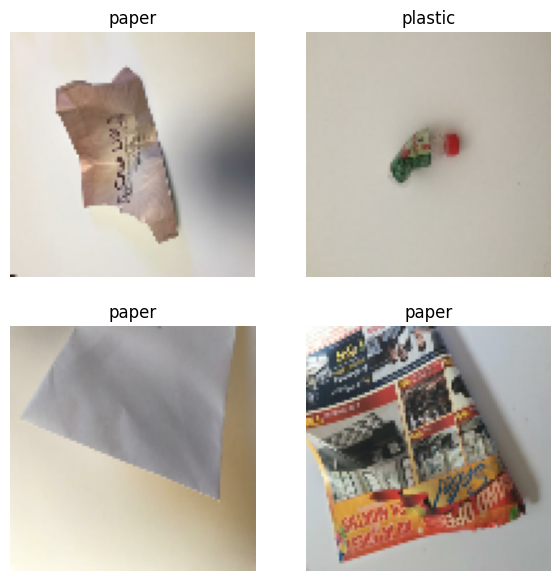

In [7]:
import matplotlib.pyplot as plt
import random

class_names = train_ds.class_names  # ['paper', 'plastic']

# Take one batch
for images, labels in train_ds.take(1):
    plt.figure(figsize=(7,7))
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        rand_index = random.randrange(len(images))  # pick random from batch
        img = images[rand_index].numpy().astype("uint8")
        label = labels[rand_index].numpy()
        plt.imshow(img)
        plt.title(class_names[label])
        plt.axis("off")
    plt.show()


In [65]:
import tensorflow as tf

# Set seed
tf.random.set_seed(42)

# Base model
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(96,96,3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # freeze base for feature extraction

# Preprocessing
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

# Build model
inputs = tf.keras.Input(shape=(96,96,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Early stopping
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Train (feature extraction)
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=15,
    callbacks=[callback]
)


Epoch 1/15
27/27 [==============================] - 79s 2s/step - loss: 0.6722 - accuracy: 0.6260 - val_loss: 0.4628 - val_accuracy: 0.8558
Epoch 2/15
27/27 [==============================] - 38s 1s/step - loss: 0.5232 - accuracy: 0.7561 - val_loss: 0.3418 - val_accuracy: 0.9209
Epoch 3/15
27/27 [==============================] - 38s 1s/step - loss: 0.4131 - accuracy: 0.8281 - val_loss: 0.2804 - val_accuracy: 0.9256
Epoch 4/15
27/27 [==============================] - 41s 2s/step - loss: 0.3698 - accuracy: 0.8548 - val_loss: 0.2465 - val_accuracy: 0.9209
Epoch 5/15
27/27 [==============================] - 40s 1s/step - loss: 0.3334 - accuracy: 0.8711 - val_loss: 0.2289 - val_accuracy: 0.9256
Epoch 6/15
27/27 [==============================] - 40s 1s/step - loss: 0.3140 - accuracy: 0.8792 - val_loss: 0.2207 - val_accuracy: 0.9256
Epoch 7/15
27/27 [==============================] - 39s 1s/step - loss: 0.2923 - accuracy: 0.8827 - val_loss: 0.2116 - val_accuracy: 0.9256
Epoch 8/15
27/27 [==

In [66]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(6, 6), text_size=12):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels."""
    
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    n_classes = cm.shape[0]

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    labels = classes if classes is not None else np.arange(n_classes)

    ax.set(
        title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels
    )

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 size=text_size)

    plt.show()


In [67]:
import numpy as np

y_probs = []
for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_probs.extend(preds)

y_probs = np.array(y_probs)
y_probs[:5]


array([[0.9887799 , 0.01122013],
       [0.98832124, 0.01167877],
       [0.9896673 , 0.0103327 ],
       [0.9725528 , 0.02744729],
       [0.8477245 , 0.15227546]], dtype=float32)

In [68]:
# See the predicted class number and label for the first example
y_probs[0].argmax(), class_names[y_probs[0].argmax()]


(0, 'paper')

In [69]:
# Convert probabilities to predicted labels
y_preds = y_probs.argmax(axis=1)

# just indices (e.g., [0, 1, 0, 1, ...])
print(y_preds[:10])

# human-readable labels (e.g., ['paper', 'plastic', 'paper', ...])
print([class_names[i] for i in y_preds[:10]])


[0 0 0 0 0 1 0 0 0 0]
['paper', 'paper', 'paper', 'paper', 'paper', 'plastic', 'paper', 'paper', 'paper', 'paper']


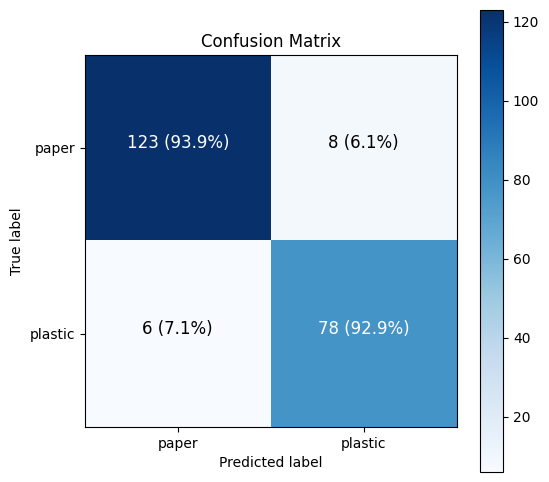

In [70]:
# Collect true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Now plot the confusion matrix
make_confusion_matrix(
    y_true=y_true,
    y_pred=y_pred,
    classes=class_names,
    figsize=(6,6),
    text_size=12
)


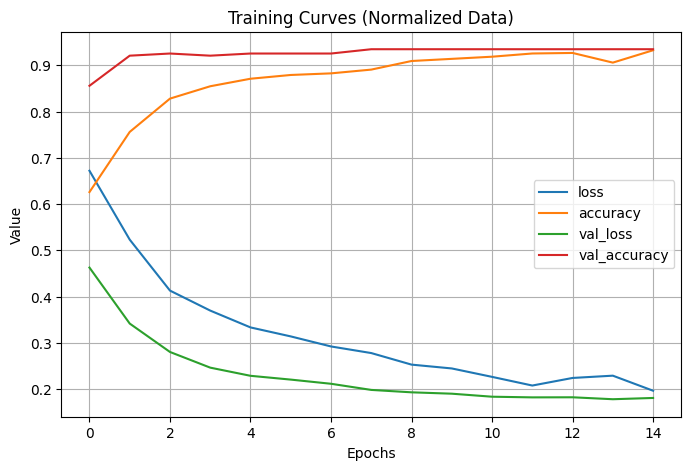

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot normalized model training history
pd.DataFrame(history.history).plot(title="Training Curves (Normalized Data)", figsize=(8,5))
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.grid(True)
plt.show()


In [72]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def plot_random_image(model, dataset, classes):
    """Picks a random image from dataset, plots it, and labels with predicted & true class."""

    # Take a batch from dataset
    images, labels = next(iter(dataset))

    # Pick random index from this batch
    i = random.randrange(len(images))

    # Grab the image and its true label
    target_image = images[i].numpy().astype("uint8")
    true_label = classes[labels[i].numpy()]

    # Predict
    pred_probs = model.predict(target_image.reshape(1,96,96,3), verbose=0)
    pred_label = classes[np.argmax(pred_probs)]
    pred_conf = 100 * np.max(pred_probs)

    # Plot the image
    plt.figure(figsize=(4,4))
    plt.imshow(target_image)
    color = "green" if pred_label == true_label else "red"
    plt.xlabel(f"Pred: {pred_label} ({pred_conf:.2f}%)\nTrue: {true_label}",
               color=color, fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.show()


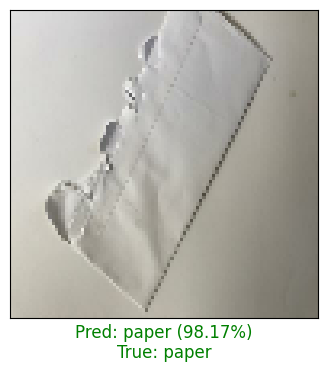

In [73]:


plot_random_image(model=model, dataset=test_ds, classes=class_names)


In [74]:
import glob
import os

# Folder with your test pics
test_folder = r"C:\Users\Owner\Desktop\python\guess"

# Grab all JPG and PNG files
image_paths = glob.glob(os.path.join(test_folder, "*.jpg")) + \
              glob.glob(os.path.join(test_folder, "*.png"))

print("Found test images:", len(image_paths))
print(image_paths[:5])  # show first few paths


Found test images: 34
['C:\\Users\\Owner\\Desktop\\python\\guess\\photo_10_2025-09-25_14-58-21.jpg', 'C:\\Users\\Owner\\Desktop\\python\\guess\\photo_11_2025-09-25_14-58-21.jpg', 'C:\\Users\\Owner\\Desktop\\python\\guess\\photo_12_2025-09-25_14-58-21.jpg', 'C:\\Users\\Owner\\Desktop\\python\\guess\\photo_1_2025-09-25_09-40-50.jpg', 'C:\\Users\\Owner\\Desktop\\python\\guess\\photo_1_2025-09-25_09-51-13.jpg']


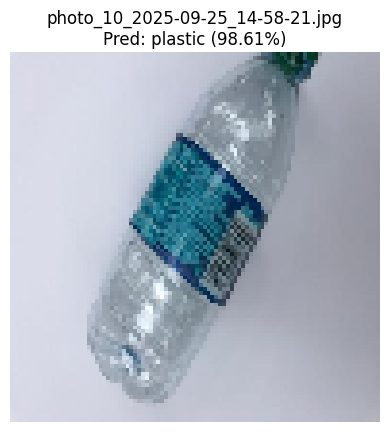

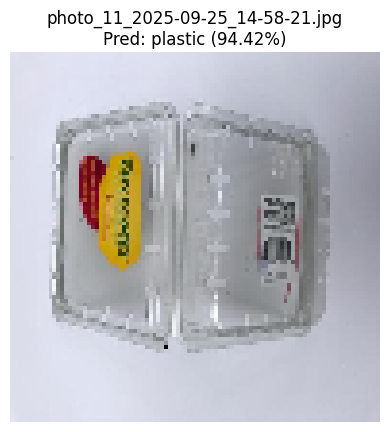

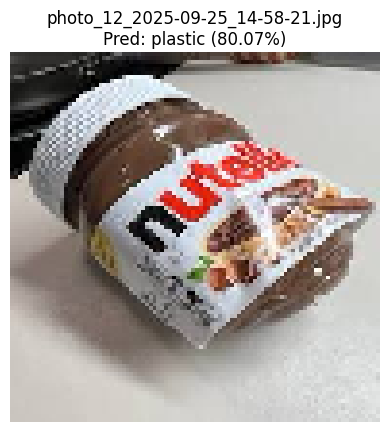

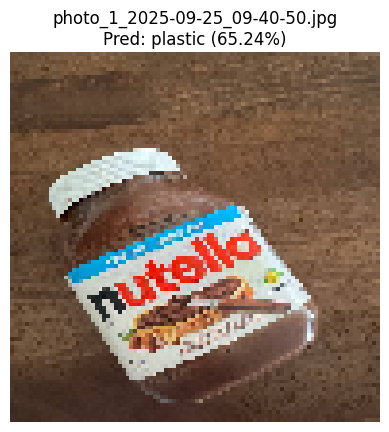

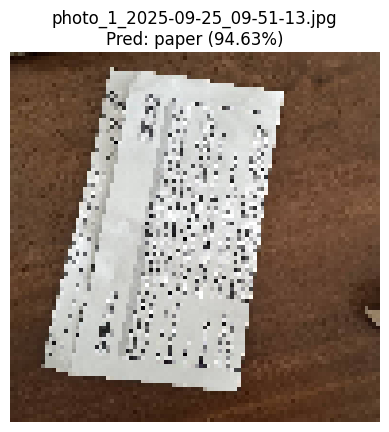

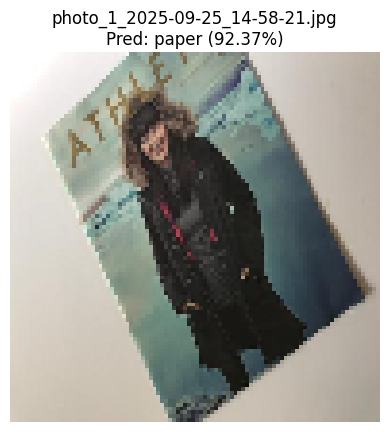

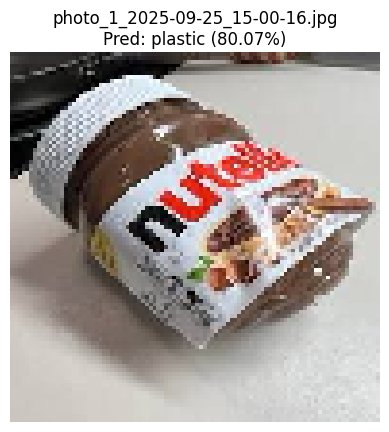

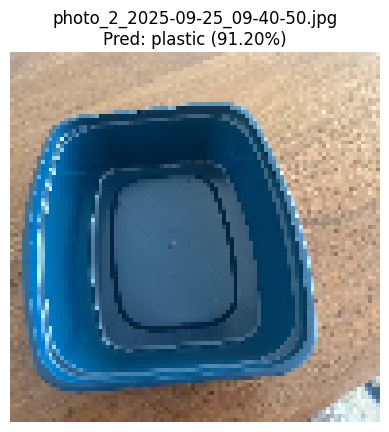

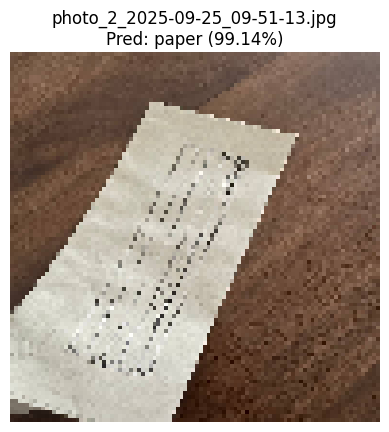

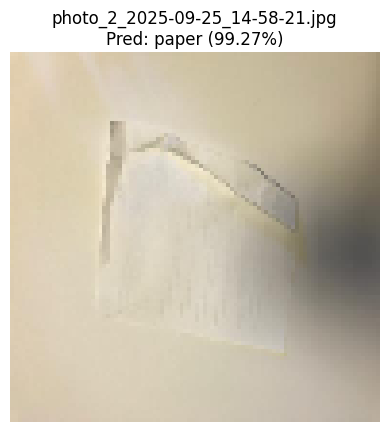

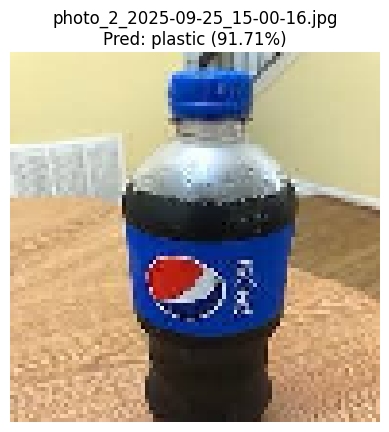

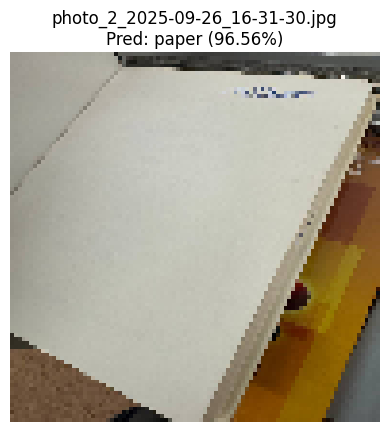

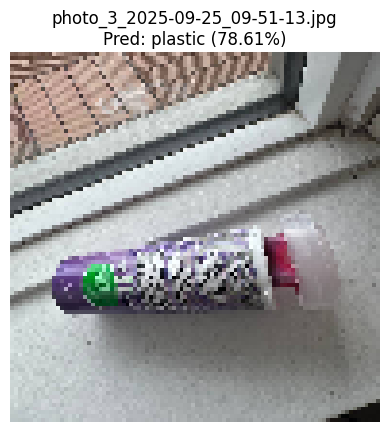

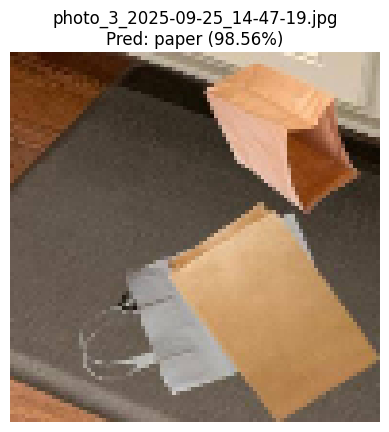

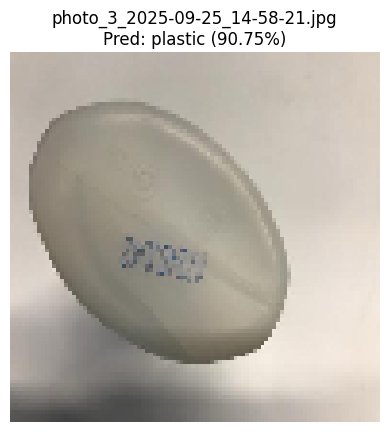

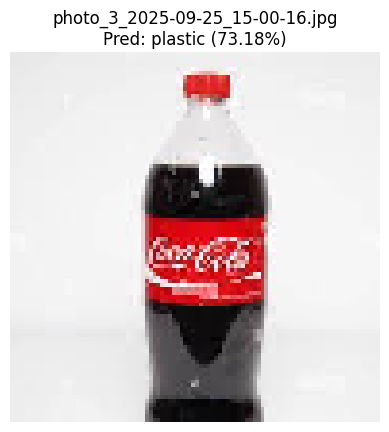

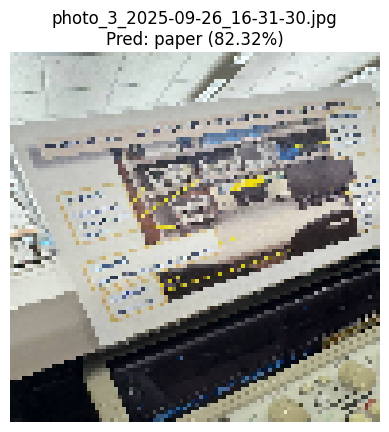

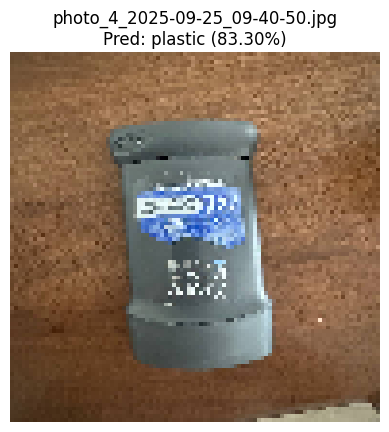

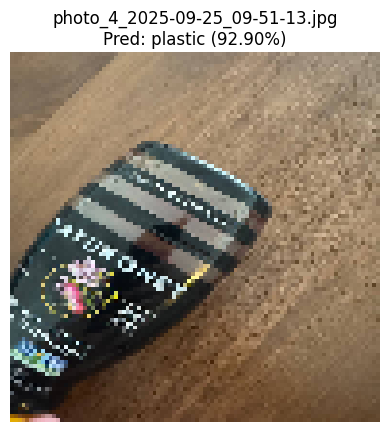

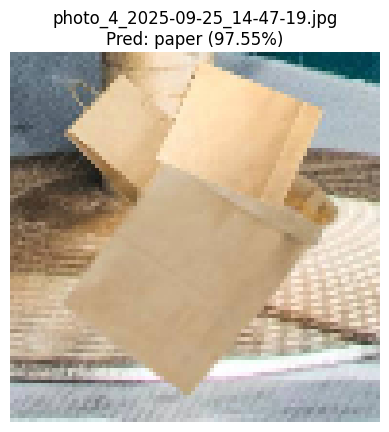

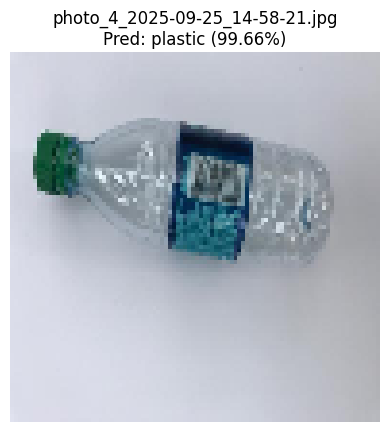

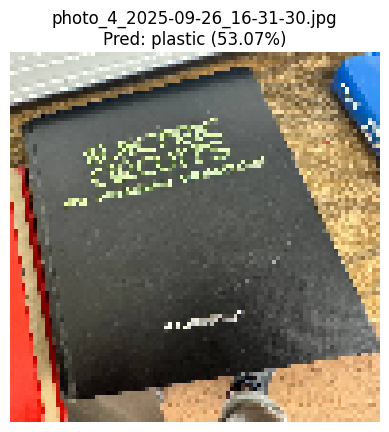

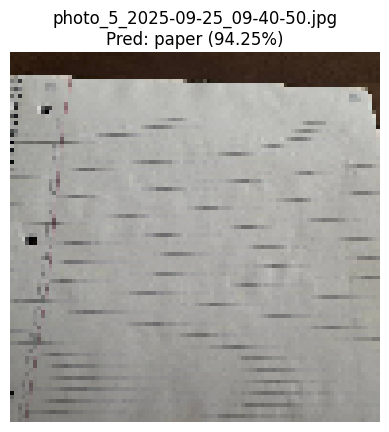

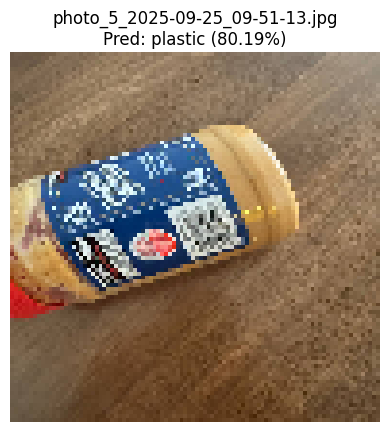

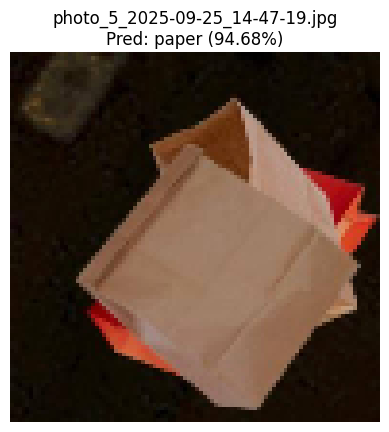

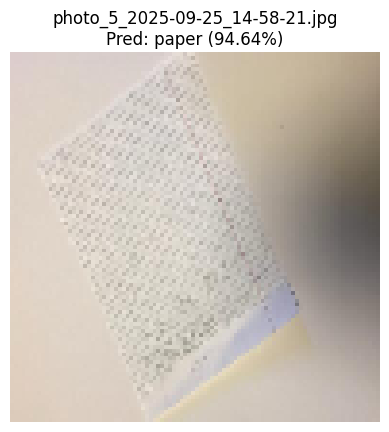

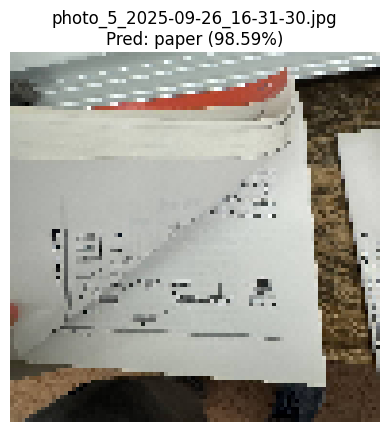

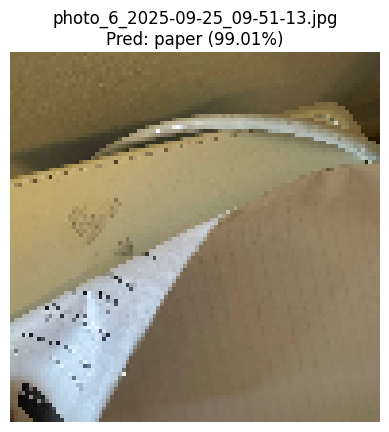

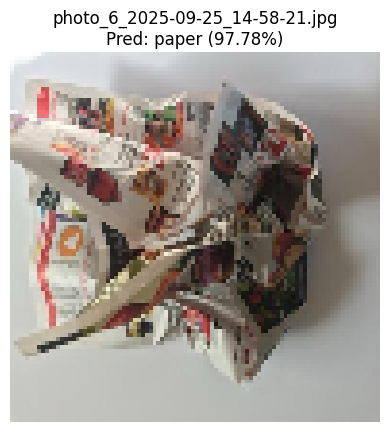

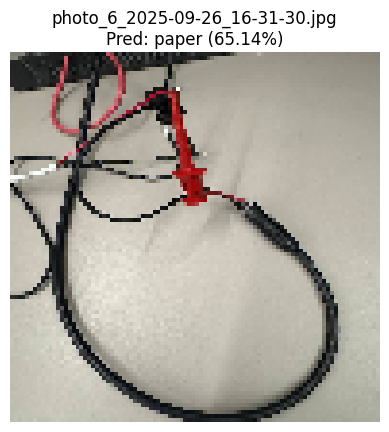

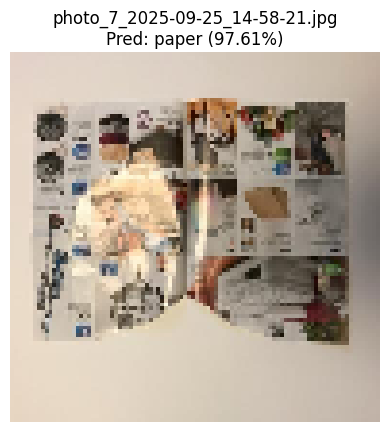

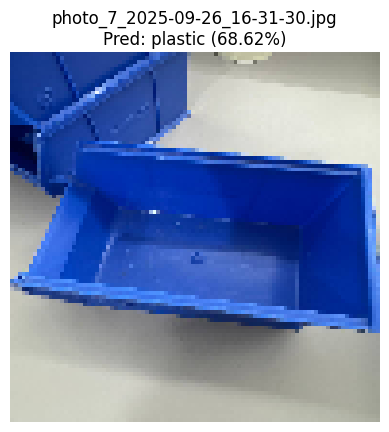

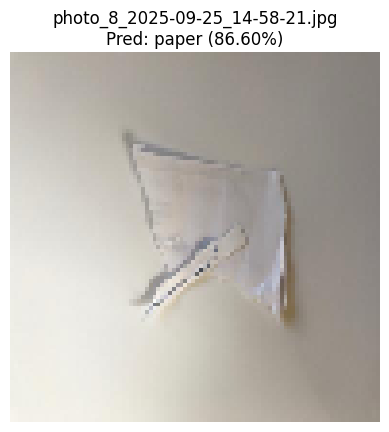

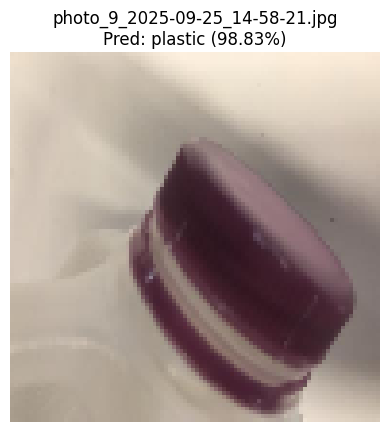

In [75]:
from tensorflow.keras.applications import efficientnet
preprocess_input = efficientnet.preprocess_input
for img_path in image_paths:
    # Load and preprocess
    img = tf.keras.utils.load_img(img_path, target_size=(96,96))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array = preprocess_input(img_array)  # ✅ match training
    
    # Predict
    preds = model.predict(img_array, verbose=0)
    pred_label = class_names[tf.argmax(preds[0])]
    pred_conf = 100 * tf.reduce_max(preds[0])

    # Show image and prediction
    plt.imshow(img)  # ✅ no .astype needed
    
    plt.title(f"{os.path.basename(img_path)}\nPred: {pred_label} ({pred_conf:.2f}%)")
    plt.axis("off")
    plt.show()
    


In [76]:
import numpy as np

y_true, y_pred = [], []
for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Compare first 20
print("True:", [class_names[i] for i in y_true[:20]])
print("Pred:", [class_names[i] for i in y_pred[:20]])


True: ['plastic', 'plastic', 'plastic', 'plastic', 'paper', 'paper', 'plastic', 'paper', 'paper', 'paper', 'paper', 'plastic', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'plastic', 'plastic']
Pred: ['plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'paper', 'plastic', 'paper', 'paper', 'paper', 'paper', 'plastic', 'paper', 'paper', 'paper', 'paper', 'paper', 'paper', 'plastic', 'plastic']


In [77]:
for img_path in image_paths:
    img = tf.keras.utils.load_img(img_path, target_size=(96,96))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array = preprocess_input(img_array)

    preds = model.predict(img_array, verbose=0)[0]
    print(os.path.basename(img_path), "->", dict(zip(class_names, preds)))


photo_10_2025-09-25_14-58-21.jpg -> {'paper': 0.013890702, 'plastic': 0.9861093}
photo_11_2025-09-25_14-58-21.jpg -> {'paper': 0.055763457, 'plastic': 0.9442366}
photo_12_2025-09-25_14-58-21.jpg -> {'paper': 0.19925387, 'plastic': 0.80074614}
photo_1_2025-09-25_09-40-50.jpg -> {'paper': 0.34761795, 'plastic': 0.6523821}
photo_1_2025-09-25_09-51-13.jpg -> {'paper': 0.9463109, 'plastic': 0.053689085}
photo_1_2025-09-25_14-58-21.jpg -> {'paper': 0.92369103, 'plastic': 0.07630898}
photo_1_2025-09-25_15-00-16.jpg -> {'paper': 0.19925387, 'plastic': 0.80074614}
photo_2_2025-09-25_09-40-50.jpg -> {'paper': 0.08804353, 'plastic': 0.9119565}
photo_2_2025-09-25_09-51-13.jpg -> {'paper': 0.99142987, 'plastic': 0.008570178}
photo_2_2025-09-25_14-58-21.jpg -> {'paper': 0.99265456, 'plastic': 0.007345395}
photo_2_2025-09-25_15-00-16.jpg -> {'paper': 0.08287454, 'plastic': 0.91712546}
photo_2_2025-09-26_16-31-30.jpg -> {'paper': 0.9655748, 'plastic': 0.0344252}
photo_3_2025-09-25_09-51-13.jpg -> {'pa

In [78]:
import os

data_dir = r"C:\Users\Owner\Desktop\python\dataset-resized"
for cname in ['paper', 'plastic']:
    folder = os.path.join(data_dir, cname)
    print(cname, ":", len(os.listdir(folder)))

paper : 594
plastic : 482


In [79]:
model.save("paper_plastic_model.keras")
loaded_model = tf.keras.models.load_model("paper_plastic_model.keras")


In [80]:
import json
with open("class_names.json", "w") as f:
    json.dump(class_names, f)

In [81]:
import os

print("Model file exists:", os.path.exists("paper_plastic_model.keras"))
print("Class names file exists:", os.path.exists("class_names.json"))


Model file exists: True
Class names file exists: True


In [82]:
loaded_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 efficientnetb0 (Functional  (None, 3, 3, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1639

In [83]:
import json
with open("class_names.json", "r") as f:
    loaded_class_names = json.load(f)

print("Loaded class names:", loaded_class_names)


Loaded class names: ['paper', 'plastic']


In [84]:
import tensorflow as tf

# Load your saved model
loaded_model = tf.keras.models.load_model("paper_plastic_model.keras")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # quantization
tflite_model = converter.convert()

# Save to file
with open("paper_plastic_model.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model saved successfully!")


INFO:tensorflow:Assets written to: C:\Users\Owner\AppData\Local\Temp\tmp3nddp62v\assets


INFO:tensorflow:Assets written to: C:\Users\Owner\AppData\Local\Temp\tmp3nddp62v\assets


TFLite model saved successfully!


Found 34 images to test.


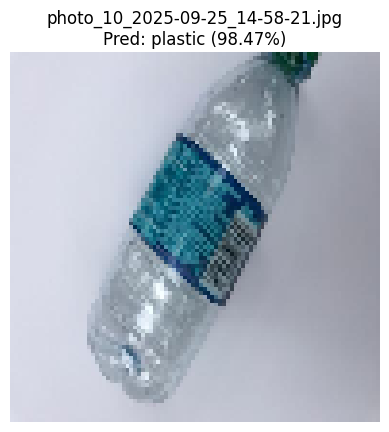

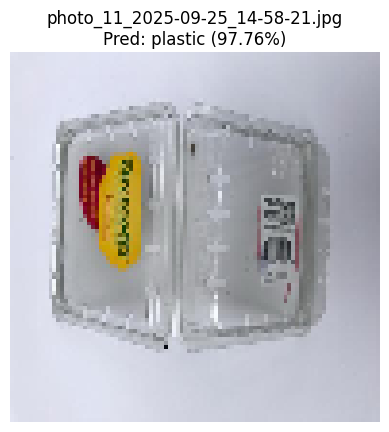

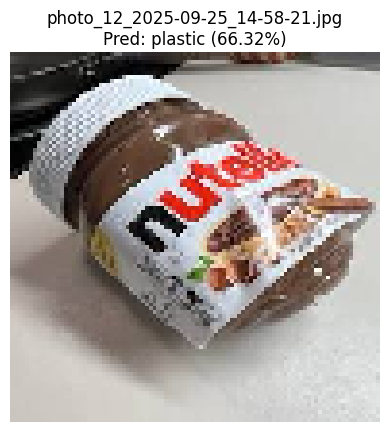

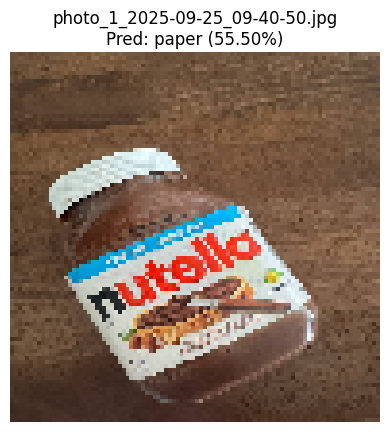

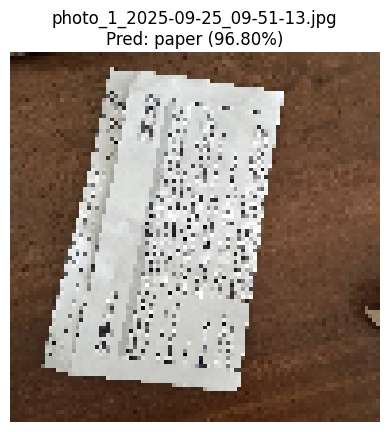

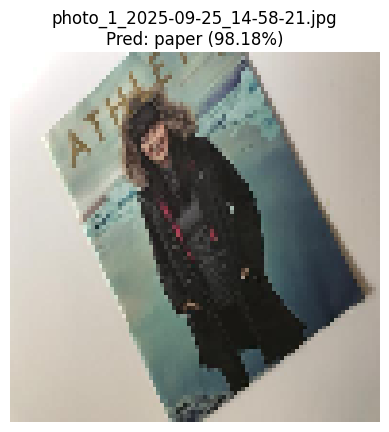

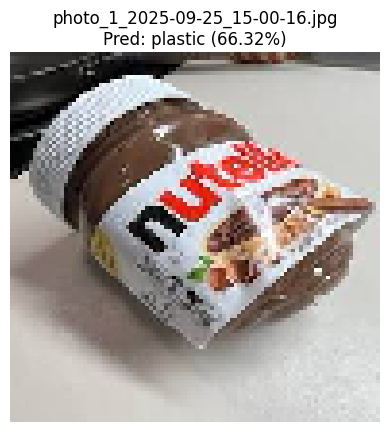

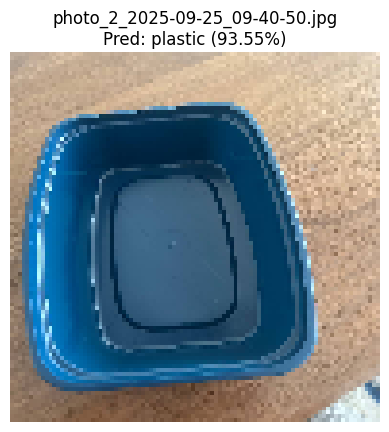

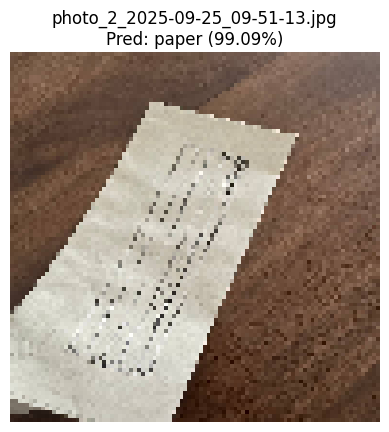

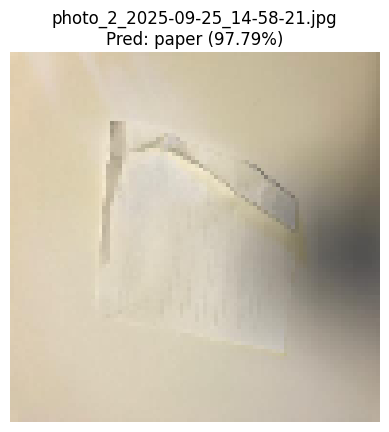

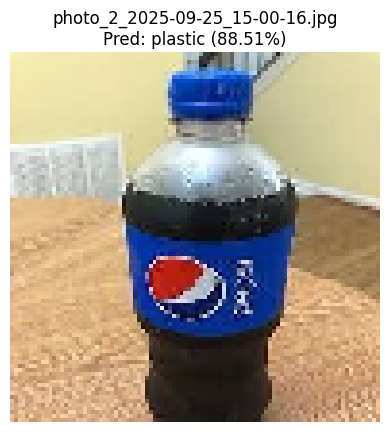

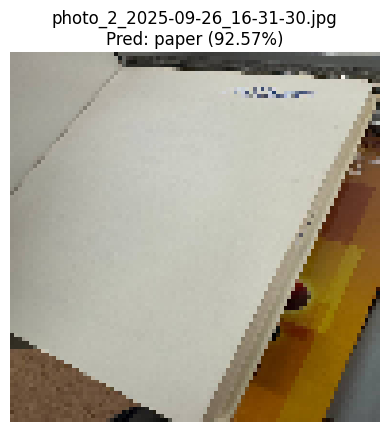

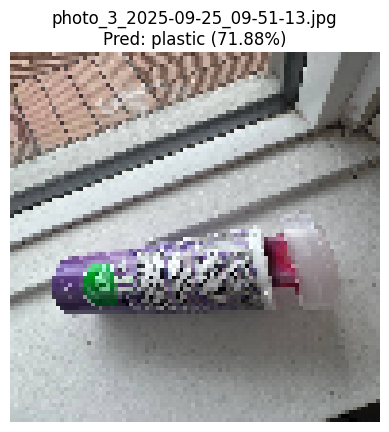

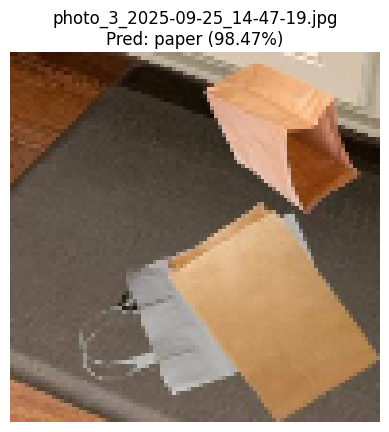

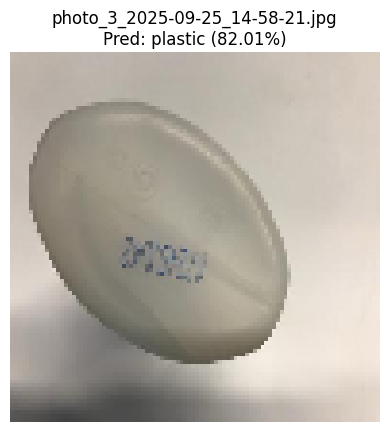

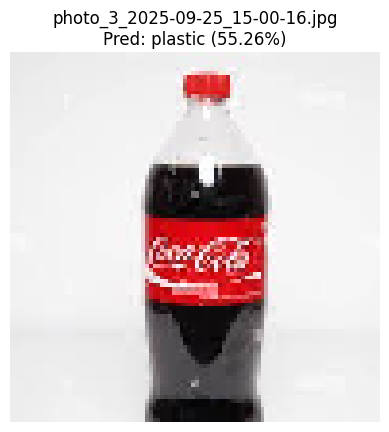

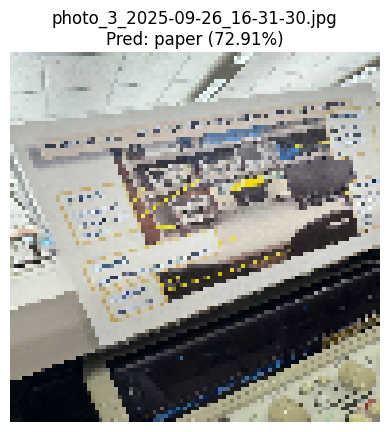

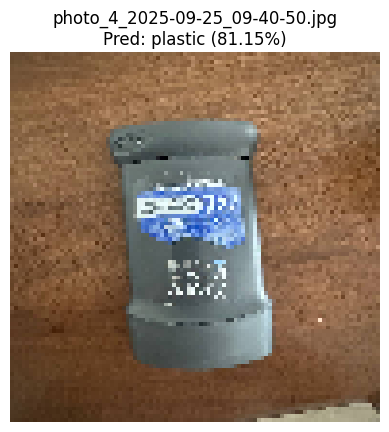

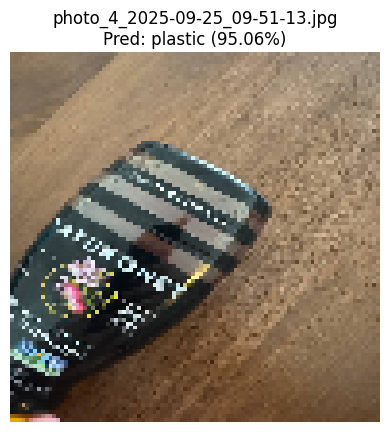

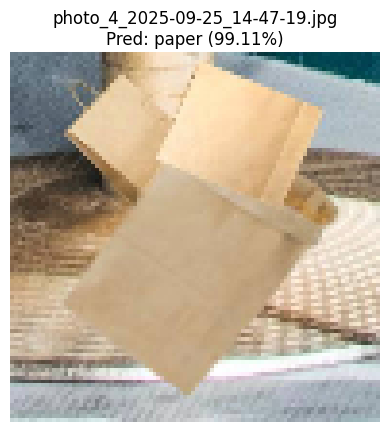

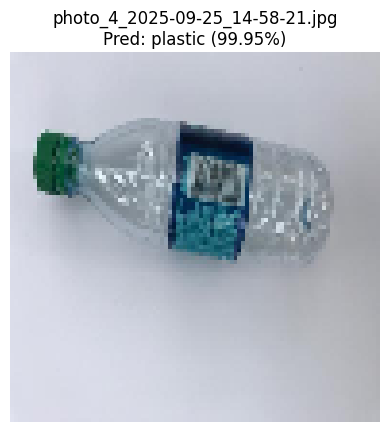

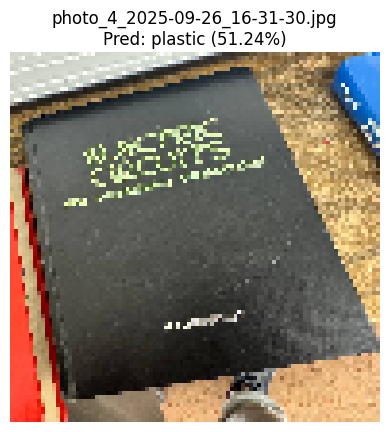

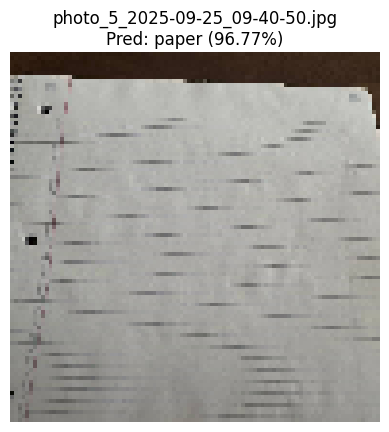

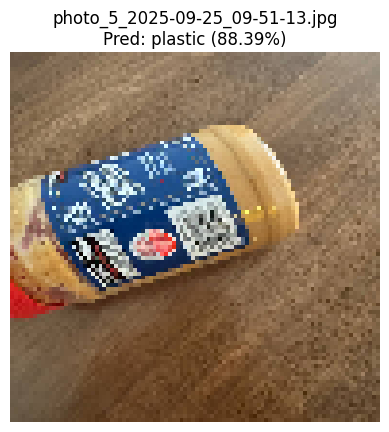

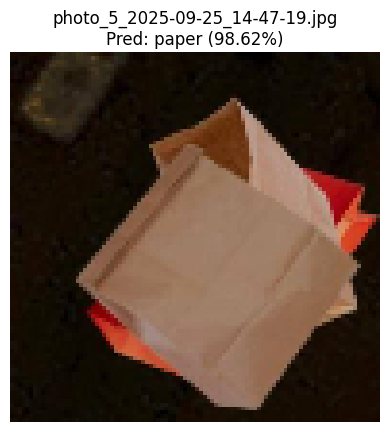

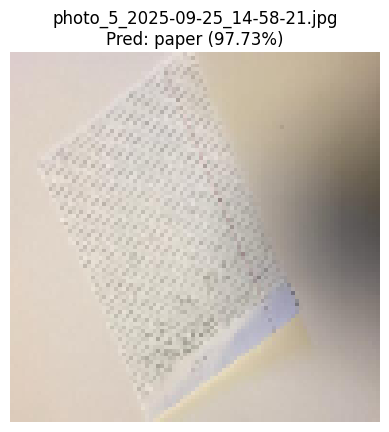

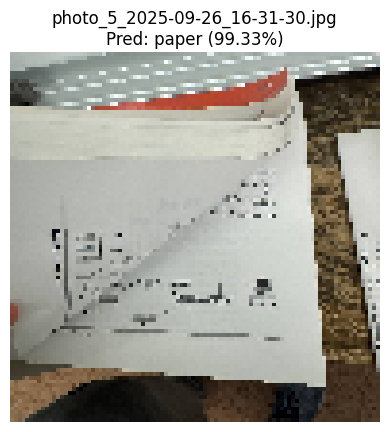

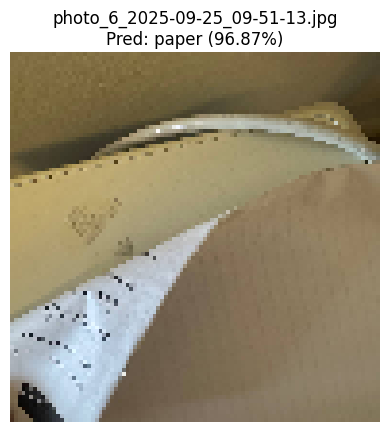

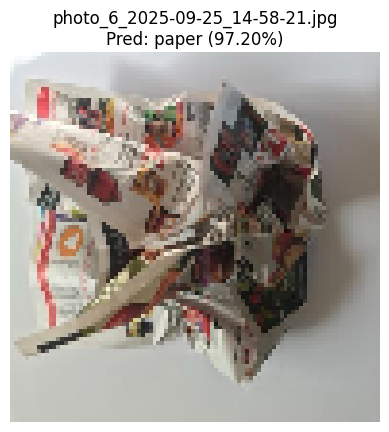

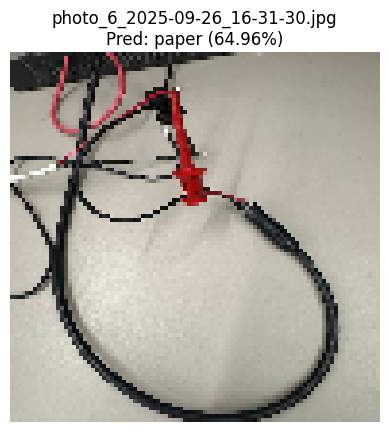

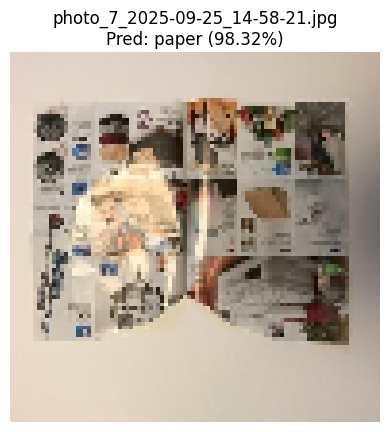

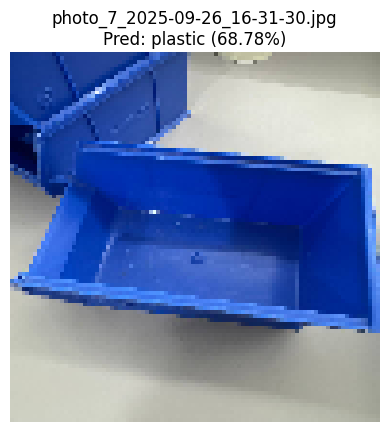

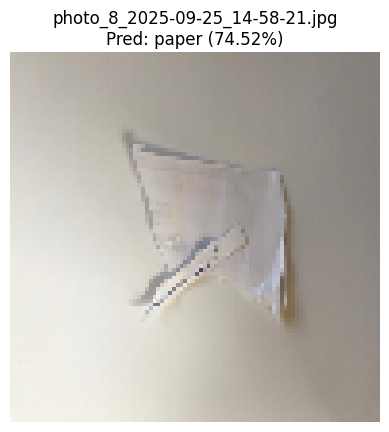

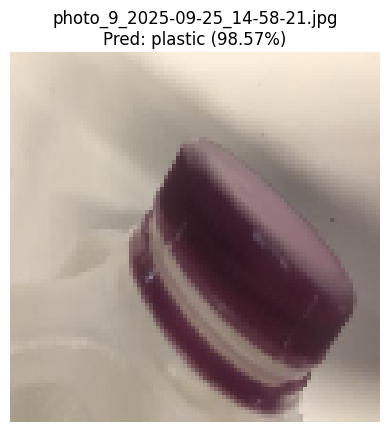

In [85]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import efficientnet

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Preprocessing (same as training)
preprocess_input = efficientnet.preprocess_input

# Define class names (adjust if swapped during training)
class_names = ["paper", "plastic"]

# Folder with your test images
folder = r"C:\Users\Owner\Desktop\python\guess"

# Collect image paths
image_paths = [os.path.join(folder, f) for f in os.listdir(folder) 
               if f.lower().endswith((".jpg", ".jpeg", ".png"))]

print(f"Found {len(image_paths)} images to test.")

for img_path in image_paths:
    # Load and preprocess
    img = tf.keras.utils.load_img(img_path, target_size=(96,96))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, 0)
    img_array = preprocess_input(img_array)

    # Run inference with TFLite
    interpreter.set_tensor(input_details[0]['index'], img_array.astype(np.float32))
    interpreter.invoke()
    preds = interpreter.get_tensor(output_details[0]['index'])[0]

    # Get prediction
    pred_label = class_names[np.argmax(preds)]
    pred_conf = 100 * np.max(preds)

    # Show result
    plt.imshow(img)
    plt.title(f"{os.path.basename(img_path)}\nPred: {pred_label} ({pred_conf:.2f}%)")
    plt.axis("off")
    plt.show()
